# 1. 题目解读
你作为新兴数据的探索者和可视化设计者，被家乡一家小型游乐园管理员的要求回答几个关于其游乐园运营相关的问题。为了进行需求分析，他们向你提供了一个数据库，其中包含游乐园一天运营相关的信息其中数据，如下：
1. checkins 登记 :
- 描述：游乐园当天所有游客的登记数据。该数据包括两类登记数据: 推测登记数据和实际登
记数据。
- 字段：visitorID, timestamp, attraction, duration, type。

2. attractions 景点:
- 游乐园景点包括相应的景点编号、名称、区域、类别和类型。区域包括VAST 挑战地图，如过山
车场区 (Coaster Alley)、 冻原之地 (Tundra Land) 等等。类别包括惊险飞车 (Thrill Rides)、儿童碰碰车
(Kiddie Rides) 等。类型包括户外过山车 (Outdoor Coaster)、其他游乐项目 (Other Ride) 、旋转木马
(Carussel) 等等。
- 字段：attractionID, name, region, category, type

3. sequences 序列 :
- 游客登记序列。这些序列显示每五分钟进入游乐场的游客位置。如果游客尚未进入游乐场，则
该时间段内序列的值为 0 。如果游客在游乐场中，则序列显示游客时间上最近登记的景点，直到该遊
客登记其他景点，或离开游乐场。
- 字段：visitorID, sequence


1: 游乐园的管理员希望你帮助他们了解游客游览游乐园的不同路线以及他们参加的不同游乐项目。在此任务中，他们随机选择了 5 名游客，并希望你分析这些游客的登记序列。现在，他们希望你针对这 5 名游客构造一个距离矩阵。五名游客的编号为：165316、1835254、296394、404385 和 448990。

2: 游乐园的管理员想要了解每个游乐项目的参加动态（请注意，并非所有景点都是游乐项目）。他们希望看到一张图(例如平行坐标图)上看到每个游乐项目的最小（非零）参入量、一整天的平均参入量以及每个游乐项目的最大参入量。

3: 除了 平行坐标图，管理员希望看到描述每个游乐项目的最小、平均和最大参入量的散点图矩阵，如上所述。

管理注意事项

为了让你的答案可以正确登记在该系统中，你必须将你的答案代码填写在每个问题对应的单元格内。此外，你的作业必须连同该单元格区域显示的代码一同提交。该显示区域应该仅仅包含你为该问题给出的答案，除此之外别无其它信息，要么就是没有正确选择答案。待评分的每个单元格在开头有几行评语。这些行极其重要，不得修改或删除。

In [83]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from pandas.plotting import parallel_coordinates
#正常显示中文
plt.rcParams["font.sans-serif"]=["SimHei"]

In [4]:
db_filename = 'dinofunworld.db'
conn = sqlite3.connect(db_filename)
c = conn.cursor()

# 2. 检查各个表格
简单打印数据表中的内容，并通过pandas.DataFrame.describe()了解数据类型以及特点。

In [5]:
# 获取表名
c.execute("select name from sqlite_master where type='table'")
tab_name=c.fetchall()
tab_name=[line[0] for line in tab_name]
tab_name

['checkin', 'attraction', 'sequences']

In [6]:
#获取表的列名（字段名），保存在col_names列表,每个表的字段名集为一个列表
col_names=[]
for line in tab_name:
    c.execute('pragma table_info({})'.format(line))
    col_name=c.fetchall()
    col_name=[x[1] for x in col_name]
    col_names.append(col_name)
    col_name=tuple(col_name)
col_names

[['index', 'visitorID', 'timestamp', 'attraction', 'duration', 'type'],
 ['index', 'AttractionID', 'Name', 'Region', 'Category', 'type'],
 ['index', 'visitorID', 'sequence']]

In [7]:
# 检查表 checkin
sql = "SELECT visitorID, timestamp, attraction, duration, type FROM checkin"
df1 = pd.read_sql(sql, conn)
print(len(df1))
print(df1.describe())
print(df1.head())

506242
          visitorID     attraction
count  5.062420e+05  506242.000000
mean   1.052300e+06      32.212315
std    6.039318e+05      25.189779
min    4.360000e+02       1.000000
25%    5.375750e+05       8.000000
50%    1.051814e+06      30.000000
75%    1.574806e+06      48.000000
max    2.096715e+06      85.000000
   visitorID            timestamp  attraction duration      type
0        436  2014-06-08 09:48:51          83  0:00:59    actual
1        436  2014-06-08 09:56:46          42  0:08:03  inferred
2        436  2014-06-08 10:14:04           6  0:06:16    actual
3        436  2014-06-08 10:29:38           5  1:07:41    actual
4        436  2014-06-08 11:38:55          49  0:08:43  inferred


In [8]:
# 检查表 attraction
sql = "SELECT attractionId, name, region, category, type FROM attraction"
df2 = pd.read_sql(sql, conn)
print(len(df2))
print(df2.describe())
print(df2.head())

71
       AttractionID
count     71.000000
mean      36.774648
std       22.110888
min        1.000000
25%       18.500000
50%       36.000000
75%       53.500000
max       85.000000
   AttractionID                    Name         Region        Category  \
0             1  Wrightiraptor Mountain  Coaster Alley  Thrill Rides\r   
1             2      Galactosaurus Rage  Coaster Alley  Thrill Rides\r   
2             3      Auvilotops Express    Tundra Land  Thrill Rides\r   
3             4              TerrorSaur       Wet Land  Thrill Rides\r   
4             5       Wendisaurus Chase    Tundra Land  Thrill Rides\r   

              type  
0  Outdoor Coaster  
1  Outdoor Coaster  
2  Outdoor Coaster  
3       Other Ride  
4  Outdoor Coaster  


In [9]:
# 检查表 sequences
sql = "SELECT visitorID, sequence FROM sequences"
df3 = pd.read_sql(sql, conn)
print(len(df3))
print(df3.describe())
print(df3.head())

11374
          visitorID
count  1.137400e+04
mean   1.054370e+06
std    6.048169e+05
min    4.360000e+02
25%    5.355695e+05
50%    1.053090e+06
75%    1.580030e+06
max    2.096715e+06
   visitorID                                           sequence
0        436  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
1        878  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
2        941  0-0-0-0-0-0-0-0-0-0-84-0-1-1-24-24-24-8-1-0-3-...
3       1197  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...
4       1217  0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...


# 3. 游客的登记序列。
经过调研，这五个visitorID的用户的登记序列总长度相等并为576.因此，计算步骤如下：
1. 先筛选出对应ID的序列。
2. 定义序列距离为：根据序列数值进行两两比较，如果对应位置相等则记为1，不相等则记为0。距离为对比结果的均值。
3. 记录对应结果并绘制热力图。

In [27]:
# 检测五个序列的长度
print('lenght of 165316 is', len(df3[df3['visitorID'] == 165316]['sequence'].values[0].split('-')))
print('lenght of 1835254 is', len(df3[df3['visitorID'] == 1835254]['sequence'].values[0].split('-')))
print('lenght of 296394 is', len(df3[df3['visitorID'] == 296394]['sequence'].values[0].split('-')))
print('lenght of 404385 is', len(df3[df3['visitorID'] == 404385 ]['sequence'].values[0].split('-')))
print('lenght of 448990 is', len(df3[df3['visitorID'] == 448990]['sequence'].values[0].split('-')))

lenght of 165316 is 576
lenght of 1835254 is 576
lenght of 296394 is 576
lenght of 404385 is 576
lenght of 448990 is 576


In [36]:
# 获取这些id的序列列表,并再一次检查长度
id_list = [165316, 1835254, 296394, 404385, 448990]
seq_list = [df3[df3['visitorID'] == i]['sequence'].values[0].split('-') for i in id_list]
print(len(seq_list))
print(len(seq_list[0]))
print(len(seq_list[1]))
print(len(seq_list[2]))
print(len(seq_list[3]))
print(len(seq_list[4]))

5
576
576
576
576
576


In [38]:
# 计算方程
def cal_dist_matrix(a_seqlist):
    tmp_res = []
    for a_sublist in a_seqlist:
        tmp_compare_res = []
        for another_sublist in a_seqlist:
            tmp_count = 0
            for index in range(len(another_sublist)):
                if a_sublist[index] == another_sublist[index]:
                    tmp_count += 1
                else:
                    continue
            tmp_compare_res.append(tmp_count / len(another_sublist))
        tmp_res.append(tmp_compare_res)
                
    return tmp_res

q1_res = cal_dist_matrix(seq_list)
# 打印结果
q1_res

[[1.0,
  0.4166666666666667,
  0.4479166666666667,
  0.4288194444444444,
  0.4479166666666667],
 [0.4166666666666667,
  1.0,
  0.5104166666666666,
  0.4826388888888889,
  0.5104166666666666],
 [0.4479166666666667, 0.5104166666666666, 1.0, 0.4739583333333333, 1.0],
 [0.4288194444444444,
  0.4826388888888889,
  0.4739583333333333,
  1.0,
  0.4739583333333333],
 [0.4479166666666667, 0.5104166666666666, 1.0, 0.4739583333333333, 1.0]]

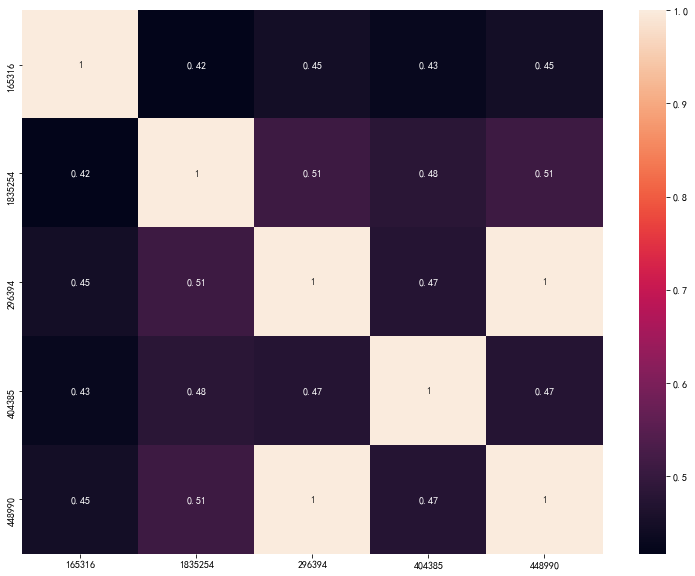

In [57]:
# 绘制热力图
plt.figure(figsize=(13,10))
ss = pd.DataFrame(q1_res, columns=[165316, 1835254, 296394, 404385, 448990], index=[165316, 1835254, 296394, 404385, 448990])
sns.heatmap(ss, annot=True)

上图可以反应每两个游客间的距离。可以发现，游客296394与448990之间的序列完全一致。

# 4. 平行坐标图
参考之前的问题，认为游乐项目为Ride。则有以下流程：
1. 确定Ride范围为attractions表中的'Thrill Rides\r','Kiddie Rides\r','Rides for Everyone\r'。
2. 获取对应游乐场的数据，并以1小时为限，计算每个游乐场每一小时的参数量。例如：9点为8.30至9.30的参入量。
3. 计算最小非零参数量、平均参入量、最大参数量。
4. 确认结果并绘制平行坐标图与boxplot。

In [62]:
# 转换timestamp时间为分钟
def transTimeToHour(a_duration):
    if a_duration is None:
        return None
    elif '@'in a_duration:
        return None
    sep_list = a_duration[:].split(':')  # 字符串切分
    hour = 0
    hour += int(sep_list[0])   # 小时
    hour += int(sep_list[1]) / 60  # 分钟转小时
    hour += int(sep_list[2]) / 60 / 60  # 秒转小时
    return round(hour)  # 每0.1小时则为每6分钟

# 获取type为actual的attraction和duration
tmp_result2 = copy.deepcopy(df1[['attraction','timestamp']][df1['type']=='actual'])
# 获取name和category
tmp_result2['name'] = tmp_result2['attraction'].apply(lambda x: df2['Name'][df2['AttractionID'] == x].values[0])
tmp_result2['category'] = tmp_result2['attraction'].apply(lambda x: df2['Category'][df2['AttractionID'] == x].values[0])
# 筛选category中为Ride的游乐装置。
tmp_result2 = tmp_result2[(tmp_result2['category']=='Thrill Rides\r') | (tmp_result2['category']=='Kiddie Rides\r') | (tmp_result2['category']=='Rides for Everyone\r')]
# duration列 dropna
tmp_result2.dropna(axis=0, subset=['timestamp'], inplace=True)
# 重新处理时间
tmp_result2['new_time'] = tmp_result2['timestamp'].apply(lambda x: transTimeToHour(x[-8:]))
tmp_result2

,attraction,timestamp,name,category,new_time
2,6,2014-06-08 10:14:04,Keimosaurus Big Spin,Thrill Rides\r,10
3,5,2014-06-08 10:29:38,Wendisaurus Chase,Thrill Rides\r,10
6,2,2014-06-08 12:49:55,Galactosaurus Rage,Thrill Rides\r,13
9,3,2014-06-08 14:05:04,Auvilotops Express,Thrill Rides\r,14
11,5,2014-06-08 15:40:10,Wendisaurus Chase,Thrill Rides\r,16
...,...,...,...,...,...
496113,13,2014-06-08 13:33:08,Cyndisaurus Asteroid,Kiddie Rides\r,14
496114,1,2014-06-08 13:48:31,Wrightiraptor Mountain,Thrill Rides\r,14
496124,30,2014-06-08 21:09:03,Ichthyoroberts Rapids,Rides for Everyone\r,21
496125,31,2014-06-08 21:50:42,Raptor Race,Rides for Everyone\r,22


In [82]:
# 获取游乐项目名称
name_list = list(tmp_result2['name'].drop_duplicates().values)
tmp_res = []
for a_name in name_list:
    tmp_sub_res = tmp_result2[tmp_result2['name'] == a_name].groupby('new_time').count()['timestamp']
    tmp_res.append([a_name, tmp_sub_res.min(), tmp_sub_res.mean(), tmp_sub_res.max()])

# check 非零最小
for a_stats in tmp_res:
    if a_stats[1] == 0:
        print(a_stats[0])
# 运行后发现所有最小都非零。

q2_res_df = pd.DataFrame(tmp_res, columns=['name', 'min', 'mean', 'max'])
q2_res_df

,name,min,mean,max
0,Keimosaurus Big Spin,15,1174.375000,1930
1,Wendisaurus Chase,42,973.375000,1676
2,Galactosaurus Rage,12,1169.687500,1865
3,Auvilotops Express,246,1245.733333,1834
4,Stegocycles,11,244.937500,472
5,Beelzebufo,61,264.200000,434
6,Enchanted Toadstools,4,234.000000,397
7,Maiasaur Madness,39,344.625000,553
8,Wrightiraptor Mountain,52,1168.437500,1840
9,Kauf's Lost Canyon Escape,46,354.000000,620


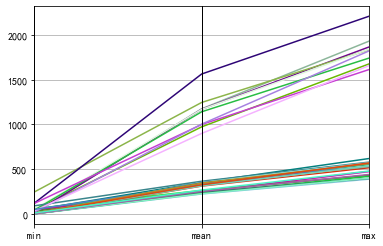

In [92]:
# 绘制平行坐标图
parallel_coordinates(q2_res_df, 'name')
plt.gca().legend_.remove()
plt.show()

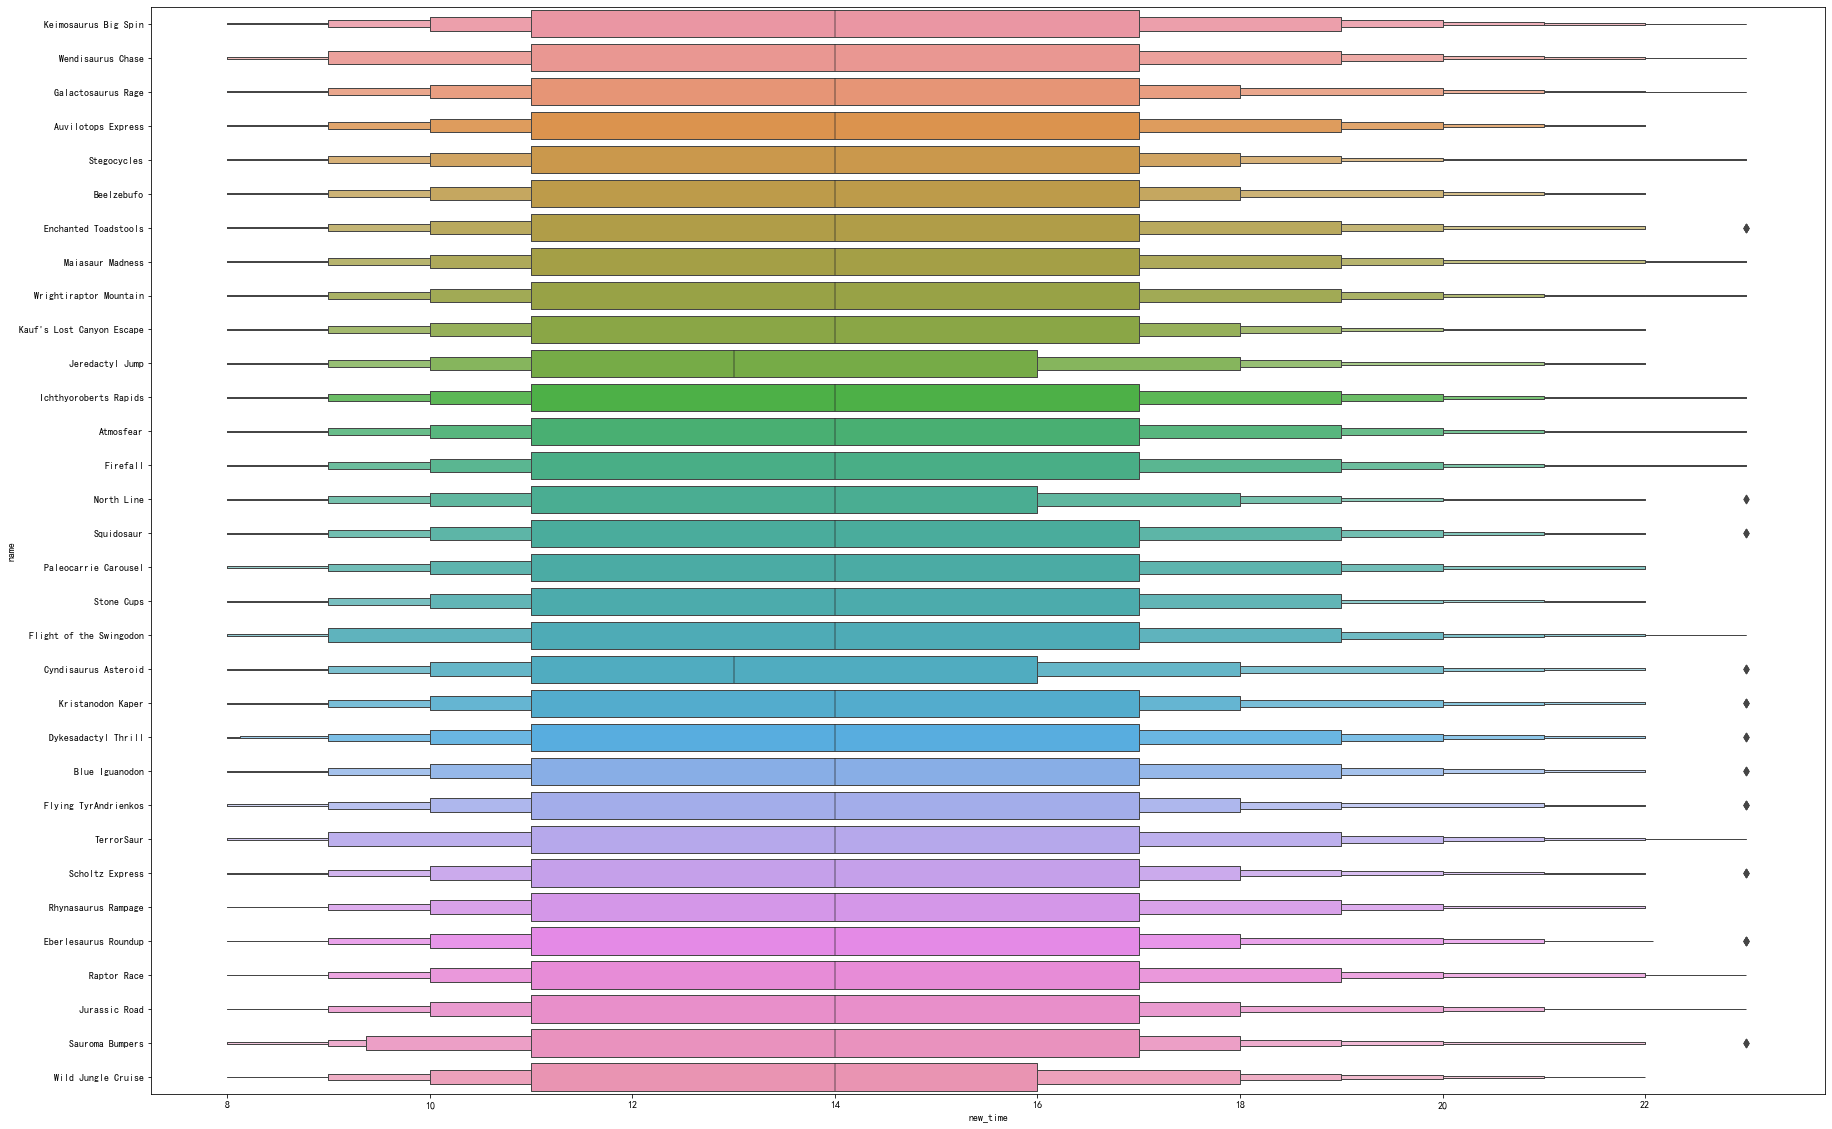

In [99]:
plt.figure(figsize=(30,20))
# 绘制多对象boxplot
sns.boxenplot(y='name', x='new_time', data=tmp_result2)

# 5. 矩阵图
根据上面问题中计算的数据。
1. 根据上一题数据，绘制散点矩阵图。

In [101]:
# 借用上一题的数据
tmp_result3_df = copy.deepcopy(q2_res_df)
tmp_result3_df

,name,min,mean,max
0,Keimosaurus Big Spin,15,1174.375000,1930
1,Wendisaurus Chase,42,973.375000,1676
2,Galactosaurus Rage,12,1169.687500,1865
3,Auvilotops Express,246,1245.733333,1834
4,Stegocycles,11,244.937500,472
5,Beelzebufo,61,264.200000,434
6,Enchanted Toadstools,4,234.000000,397
7,Maiasaur Madness,39,344.625000,553
8,Wrightiraptor Mountain,52,1168.437500,1840
9,Kauf's Lost Canyon Escape,46,354.000000,620


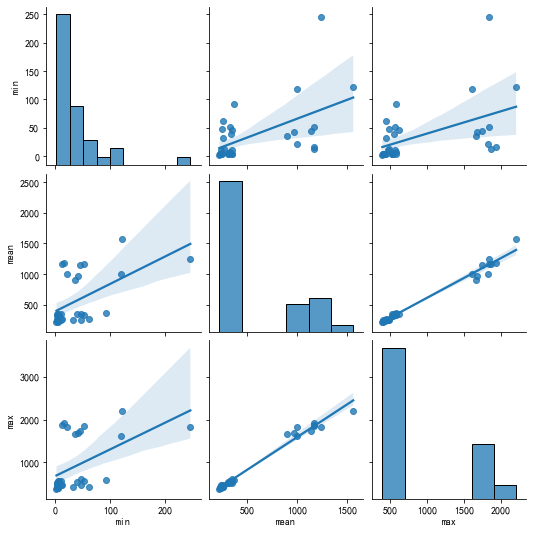

In [108]:
sns.pairplot(tmp_result3_df, kind='reg', diag_kind='auto')

以上完成散点图矩阵，以min、mean、max为变量绘制。这里比较有趣的是，对角线的图是对应变量的柱状图。这样可以带来更多的信息量。